In [360]:
import pandas as pd
data=pd.read_csv("FAOLEX.csv")
print(data.keys())

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [361]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1




In [362]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])




In [363]:
# Ignore
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [365]:
print(keywords[15])
print(stemmed_words[15])


['marine fisheries', ' traditional rights/customary rights', ' fishing authorization', ' allocation/quota', ' fishery management and conservation']
['marine fisheri', ' traditional rights/customary right', ' fishing author', ' allocation/quota', ' fishery management and conserv']


# Top2vec topic model

In [263]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


2023-06-01 09:42:06,274 - top2vec - INFO - Pre-processing documents for training
2023-06-01 09:42:15,946 - top2vec - INFO - Creating joint document/word embedding
2023-06-01 09:45:12,098 - top2vec - INFO - Creating lower dimension embedding of documents
2023-06-01 09:46:33,458 - top2vec - INFO - Finding dense areas of documents
2023-06-01 09:46:39,738 - top2vec - INFO - Finding topics


In [264]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([1559, 1368, 1237, ...,   20,   18,   18])

In [265]:
model.get_num_topics()

1156

In [266]:
topic_words,word_scores,topic_nums = model.get_topics(5)

In [ ]:
#print(topic_words)

[['mesh' 'fishing' 'method' 'charge' 'fisheries' 'fishes' 'gear'
  'seasons' 'crustaceans' 'vessel' 'catch' 'commercial' 'cartilaginous'
  'size' 'bycatch' 'allowable' 'total' 'prohibited' 'fishery' 'mammals'
  'landing' 'transshipment' 'port' 'quota' 'allocation' 'diadromous'
  'high' 'marine' 'turtles' 'foreign' 'molluscs' 'seas' 'migratory'
  'artisanal' 'state' 'stock' 'mariculture' 'unregulated' 'enhancement'
  'repopulation' 'iuu' 'unreported' 'illegal' 'exclusive' 'methods' 'sea'
  'eez' 'economic' 'area' 'inland']
 ['territorial' 'maritime' 'sea' 'exclusive' 'continental' 'eez' 'shelf'
  'economic' 'high' 'seas' 'zone' 'deep' 'transshipment' 'sovereignty'
  'harbour' 'vessel' 'fishing' 'mesh' 'navigation' 'marine' 'foreign'
  'port' 'bycatch' 'fisheries' 'cartilaginous' 'allowable' 'total'
  'catch' 'method' 'state' 'coastal' 'charge' 'diadromous' 'landing'
  'unregulated' 'unreported' 'bed' 'iuu' 'fishes' 'mariculture'
  'migratory' 'mammals' 'fishery' 'illegal' 'survey' 'comm

In [268]:
# Find documents most similar to a specific topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=110, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 115013, Score: 0.9707304239273071
-----------
fishery management and conservation international agreement-text biodiversity
-----------

Document: 118371, Score: 0.9685155153274536
-----------
international agreement-text international trade animal health quarantine
-----------

Document: 89199, Score: 0.9650817513465881
-----------
international agreement-text energy conservation/energy production international agreement-text
-----------

Document: 17535, Score: 0.9650720357894897
-----------
international agreement-text animal health
-----------

Document: 46065, Score: 0.9645030498504639
-----------
animal health international agreement-text international trade
-----------

Document: 129251, Score: 0.9629270434379578
-----------
international agreement-text agricultural development
-----------

Document: 118362, Score: 0.9607734680175781
-----------
international agreement-text
-----------

Document: 17524, Score: 0.9600027203559875
-----------
international agreement-text

In [269]:
# Check documents
data.iloc[370]

Record Id                                                     LEX-FAOC001446
Record URL                 http://www.fao.org/faolex/results/details/en/c...
Document URL                     https://faolex.fao.org/docs/pdf/ivc1446.pdf
Title                      Décret nº 66-399 portant création d'un Comité ...
Original title                                                           NaN
Date of original text                                             13-09-1966
Last amended date                                                        NaN
Available website                                                        NaN
Language of document                                                  French
Country/Territory                                              Côte d'Ivoire
Regional organizations                                                   NaN
Territorial subdivision                                                  NaN
Type of text                                                      Regulation

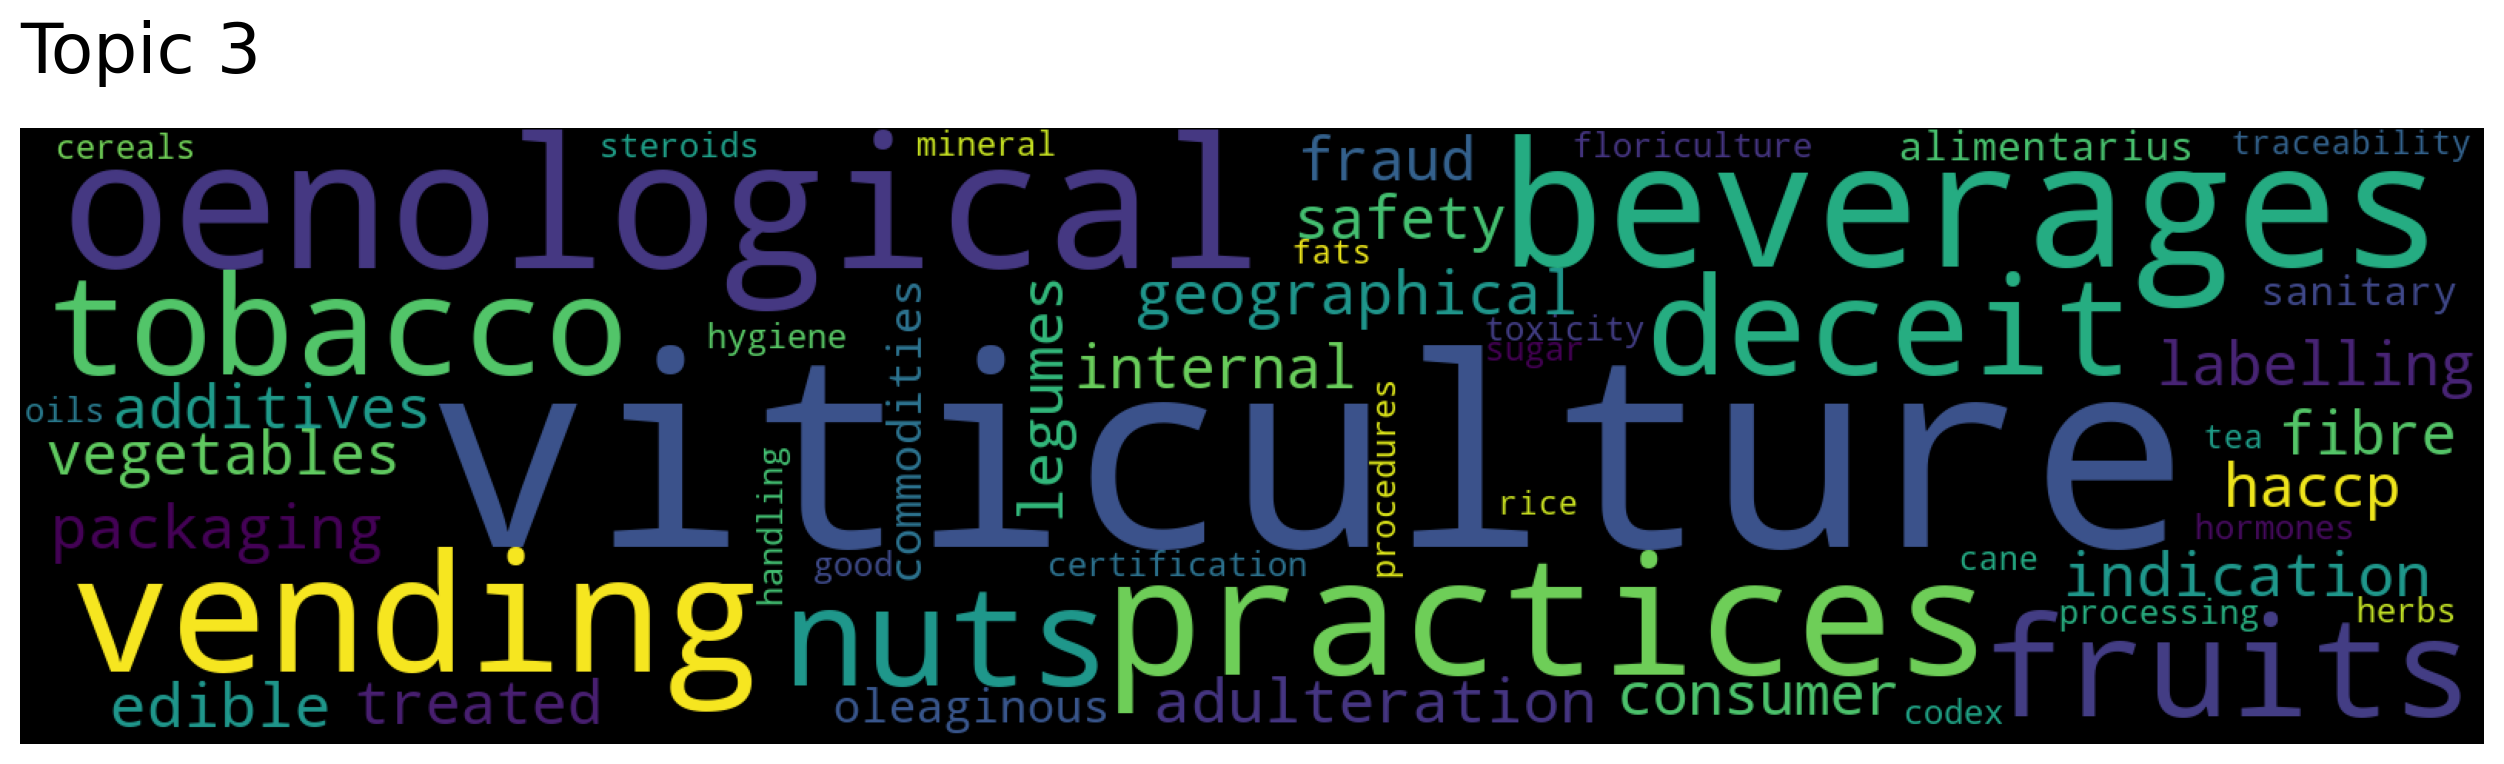

In [270]:
model.generate_topic_wordcloud(3)

In [100]:
# Look up topics corresponding to a keyword
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["waste"], num_topics=10)
print(topic_words)
print(topic_nums)
print(topic_scores)

[array(['sources', 'pays', 'polluter', 'domestic', 'waste', 'solid',
       'prevention', 'recycling', 'disposal', 'principle', 'reuse',
       'hazardous', 'movement', 'air', 'substances', 'pollution',
       'control', 'audit', 'precautionary', 'discharge', 'environmental',
       'effluent', 'plastic', 'noise', 'circular', 'rehabilitation',
       'ozone', 'charges', 'emissions', 'impact', 'freshwater',
       'industrial', 'economy', 'sewerage', 'eia', 'layer',
       'transboundary', 'compensation', 'clean', 'groundwater', 'soil',
       'payments', 'water', 'bioenergy', 'trading', 'assessment', 'prior',
       'ecofriendly', 'healthy', 'loss'], dtype='<U15'), array(['domestic', 'sources', 'solid', 'waste', 'prevention', 'disposal',
       'recycling', 'rehabilitation', 'reuse', 'hazardous', 'effluent',
       'discharge', 'substances', 'soil', 'movement', 'control',
       'pollution', 'pays', 'polluter', 'audit', 'erosion',
       'environmental', 'sewerage', 'improvement', 'pla

## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [474]:
# Compute uniqe countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [471]:
#View all countries
#set(country_new)

In [475]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1


In [476]:
# Compute country x topic occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes()
country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1



In [348]:
#Standardisering
""" 
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)
for i in range(len(countries)):
    country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i]) 
"""

In [442]:
def square_rooted(x):
        return np.sqrt(sum([a*a for a in x]))
def co_occurence(country_new,similarity):
    country_co_ocurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_ocurrence[i,j] = np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1]
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_ocurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[i,:]))
            
    return country_co_ocurrence

country_co_ocurrence = co_occurence(country_new,"correlation")
np.shape(country_co_ocurrence)

(257, 257)

# Country Network

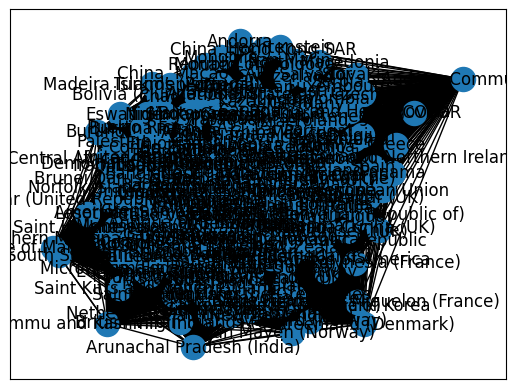

In [490]:
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

G = nx.Graph()

size = country_co_ocurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_ocurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_ocurrence[i, j])

for i in range(size):
    if np.sum(country_co_ocurrence[i])==0:
        G.remove_node(i)
        countries_swap.pop(i)


nx.draw_networkx(G, labels=countries_swap,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

In [388]:
from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)

most_central_edge(G)

(153, 251)

In [494]:
NUM_ITERATIONS = 2000
for i in range(NUM_ITERATIONS):
    edge_betweenness = nx.edge_betweenness_centrality(G).items()
    edge_to_delete = sorted(edge_betweenness, key=lambda pair: -pair[1])[0][0]

    G.remove_edge(*edge_to_delete)
    #print('Step %s\nEdge %s Deleted'%(i, edge_to_delete))
nx.draw_networkx(G, labels=countries_swap,with_labels=True)


KeyboardInterrupt: 

# Forskellige topic reduction

In [35]:
topic_mapping = model.hierarchical_topic_reduction(num_topics=200)

KeyboardInterrupt: 

In [197]:
print(model.topic_words_reduced)

[['steroids' 'hormones' 'mrl' 'residue' 'drugs' 'limit' 'hygiene'
  'maximum' 'swine' 'procedures' 'residues' 'sanitary' 'feed'
  'feedstuffs' 'veterinary' 'animal' 'toxicity' 'poultry' 'poisoning'
  'equine' 'slaughtering' 'meat' 'cattle' 'sheep' 'vaccination' 'goats'
  'additives' 'health' 'dairy' 'mercosur' 'safety' 'disinfestation'
  'codex' 'inspection' 'rodents' 'treated' 'haccp' 'disinfection'
  'andean' 'edible' 'packaging' 'pests' 'traceability' 'trade'
  'antimicrobial' 'diseases' 'welfare' 'labelling' 'milk' 'alimentarius']
 ['equine' 'sheep' 'swine' 'goats' 'cattle' 'rodents' 'herd' 'camelids'
  'book' 'reproduction' 'poultry' 'animal' 'slaughtering' 'vaccination'
  'mercosur' 'animals' 'welfare' 'meat' 'health' 'disinfestation' 'birds'
  'jersey' 'hygiene' 'sericulture' 'apiculture' 'steroids' 'hormones'
  'drugs' 'procedures' 'disinfection' 'quarantine' 'identification'
  'north' 'pests' 'feed' 'sanitary' 'ranching' 'inspection' 'marking'
  'captive' 'diseases' 'edible' '

In [202]:
model.topic_words_reduced[4]

array(['viticulture', 'oenological', 'tribunal', 'court', 'herzegovina',
       'beverages', 'tobacco', 'geographical', 'bosnia', 'indication',
       'fraud', 'settlement', 'codex', 'inspection', 'lao',
       'compensation', 'dispute', 'intellectual', 'labelling', 'trade',
       'certification', 'justice', 'practices', 'consumer', 'lanka',
       'liability', 'packaging', 'deceit', 'information', 'plant',
       'haccp', 'traceability', 'alimentarius', 'offences', 'internal',
       'tristan', 'adulteration', 'classification', 'singapore',
       'breeders', 'access', 'seeds', 'commodities', 'vested', 'sugar',
       'floriculture', 'veterinary', 'liechtenstein', 'legal',
       'agricultural'], dtype='<U14')

In [82]:
topic_words,word_scores,topic_nums = model.get_topics(10)
topic_words

array([['mesh', 'fishing', 'seasons', 'size', 'fishery', 'method',
        'cartilaginous', 'catch', 'bycatch', 'fisheries', 'landing',
        'prohibited', 'marine', 'total', 'allowable', 'charge',
        'allocation', 'fishes', 'vessel', 'gear', 'quota', 'artisanal',
        'foreign', 'commercial', 'diadromous', 'port', 'migratory',
        'transshipment', 'turtles', 'mammals', 'molluscs', 'crustaceans',
        'illegal', 'high', 'seas', 'inland', 'iuu', 'territorial',
        'unregulated', 'area', 'exclusive', 'state', 'eez',
        'enhancement', 'management', 'conservation', 'coral',
        'unreported', 'repopulation', 'sea'],
       ['floriculture', 'planting', 'seeds', 'material', 'fibre',
        'plant', 'cane', 'beet', 'variety', 'vegetables', 'breeders',
        'oleaginous', 'legumes', 'fruits', 'edible', 'nuts', 'sugar',
        'certification', 'rice', 'tobacco', 'cereals', 'labelling',
        'weeds', 'crops', 'oenological', 'production', 'packaging',
        '

# Data analyse

In [78]:
print(keywords[15])
print(len(keywords[15]))

marine fisheries traditional rights/customary rights fishing authorization allocation/quota fishery management and conservation
127


In [66]:
# Tæl hvor mange der er repealed inden for et dato interval
dates=data["Date of original text"]
repealed=data["Repealed"]
antal=0
for i in range(1800,2022):
    c=dates==str(i)
    d=repealed=="Y"
    antal+=sum(c*d)
print(antal)


965


In [ ]:
#Append country to keywords -- outdated
#i=0

#for words in keywords:
 #   keywords[i]=words + [" "+country[i]]
  #  i+=1

In [ ]:
# Find number of extinct domains
a= list(set(data["Domain"]))
i=0
for words in a:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="Nan"
    a[i]=words.split(";")

    i+=1

In [ ]:
# print different domains
a=sum(a,[])
i=0
for word in a:
        word=word.strip()
        a[i]=word
        i+=1

print(set(a))



In [ ]:
# Count number documents in a language
languages=list(data["Language of document"])
print(languages.count("English"))

In [125]:
set(country)

{'Cameroon; Senegal',
 'Armenia; Azerbaijan; Belarus; Kazakhstan; Kyrgyzstan; Republic of Moldova; Russian Federation; Tajikistan; Turkmenistan; Uzbekistan; Ukraine',
 'European Union; Sao Tome and Principe',
 'Switzerland; Uzbekistan',
 'Russian Federation; Jordan',
 'Russian Federation; Saudi Arabia',
 'Portugal; Mozambique; Eswatini',
 'France; India',
 'Central African Republic',
 'Germany; Latvia',
 'Angola; Botswana; Democratic Republic of the Congo; Lesotho; Malawi; Mauritius; Mozambique; Namibia; Seychelles; South Africa; Eswatini; United Republic of Tanzania; Zambia; Zimbabwe',
 'Uruguay; Brazil',
 'Philippines; Indonesia',
 'Clipperton Island (France)',
 "Benin; Burkina Faso; Cameroon; Chad; Côte d'Ivoire; Guinea; Mali; Niger; Nigeria",
 'United States of America; American Samoa (USA)',
 'Senegal; United States of America',
 'Qatar',
 'China; Australia',
 'Papua New Guinea; Solomon Islands',
 'Cabo Verde; Japan',
 'Northern Mariana Islands (USA)',
 'United Kingdom of Great Br

- Cluster topics
- Dendogram